In [406]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects  # Import path effects for text outline
import pandas as pd


In [407]:
# avg_power 378.8556695697469 std_power 3.631425271401822

# avg_power 93.54626298542978 std_power 2.497080950805588
# avg_power 93.95008267753535 std_power 2.7211928636453404

BASE_MEAN_mW = 378.8556695697469
BASE_STD_mW = 3.631425271401822

SMALL_MEAN_mW = 93.54626298542978
SMALL_STD_mW = 2.497080950805588

BART_MEAN_mW = 93.95008267753535
BART_STD_mW = 2.7211928636453404

In [408]:
def load_task_records(file_path):
    """Load task records from a CSV file."""
    try:
        task_records = pd.read_csv(file_path)
        return task_records
    except Exception as e:
        print(f"Error loading task records: {e}")
        return None

In [409]:
def generate_gantt_arrival_ending_time(task_records):

    # check if task_records["Task_Retrain"] contains -1 values
    is_retrain = -1 not in list(task_records["Task_Retrain"].unique())

    # Extract unique GPU IDs from the task records DataFrame
    gpus = task_records['GPU_ID'].unique()
    print(type(gpus))  # Should be a numpy array or similar

    wait_color = '#2C7865'  
    burst_color = '#FF9800'   

    min_start_time = task_records["Start_Time"].min()
    min_arrival_time = task_records["Arrival_Time"].min()

    fig, axs = plt.subplots(4, 2, figsize=(15, 10))  # Adjust figsize if needed

    # Iterate over GPUs to create individual plots
    for g in gpus:
        gpu_index = g - 1
        r = gpu_index // 2
        c = gpu_index % 2

        # Filter tasks for the current GPU
        gpu_tasks = task_records[task_records['GPU_ID'] == g]
        tot_training_time = gpu_tasks['Training_Time'].sum()
        print(f"GPU {g} Tasks: {len(gpu_tasks)}, Total Training Time: {tot_training_time}, Unique Users: {gpu_tasks['User_ID'].nunique()}")

        for i, row in gpu_tasks.iterrows():
            arrival = row['Arrival_Time'] - min_arrival_time
            start = row['Start_Time'] - min_start_time
            training = row['Training_Time']
            user_id = row['User_ID']

            wait_time = start - arrival  # Calculate wait time

            # Plot wait time segment
            if wait_time > 0:  # Ensure wait time is positive
                axs[r, c].barh(y=i, width=wait_time, left=arrival, color=wait_color, edgecolor='black', align="center")

            # Plot burst time segment (training time)
            axs[r, c].barh(y=i, width=training, left=start, color=burst_color, edgecolor='black', align="center")

            # Center the user ID label on the burst time bar
            mid_point = start + training / 2
            if not is_retrain:
                text = axs[r, c].text(mid_point, i, f"User {user_id}", va='center', ha='center', color='black', fontsize=8)

                # Apply white outline around the text
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

        
        # Configure chart
        axs[r, c].set_yticks([])  # Optionally set Y ticks based on tasks if needed
        axs[r, c].set_xlabel("Time[h]")
        axs[r, c].set_title(f"GPU {g}")

    # Add legend outside the loop, only once at the bottom right
    handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor=wait_color, edgecolor='black'),
        plt.Rectangle((0, 0), 1, 1, facecolor=burst_color, edgecolor='black')
    ]

    if not is_retrain:
        fig.legend(handles, ["Wait Time", "Burst Time", "User ID"], title="Task Segments", loc='lower right', 
           bbox_to_anchor=(0.75, 0.1), fontsize=12, title_fontsize=12)

    # Hide any extra subplot, e.g., the bottom right plot in a 4x2 grid when there are only 7 GPUs
    if len(gpus) < 8:
        axs[3, 1].axis('off')  # Turn off the bottom-right subplot
    
    plt.tight_layout()  # Adjust layout to prevent clipping of elements

    fig.suptitle("Gantt Chart of Task Wait and Burst Time", fontsize=16, x=0.5, y=1.05)
    plt.show()  # Display all subplots at once

# Assuming you have a DataFrame `task_records` already defined
# generate_gantt_arrival_ending_time(task_records)

In [410]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def get_gpus(task_records):
    """Get unique GPU IDs from task records."""
    gpu_ids = []  # Initialize an empty list to store unique GPU IDs

    # Iterate through each record in the task_records DataFrame
    for _, record in task_records.iterrows():
        gpu_id = record['GPU_ID']

        if gpu_id not in gpu_ids:
            gpu_ids.append(gpu_id)

    return gpu_ids

def generate_gantt_gantt_executions(task_records):
    gpus = get_gpus(task_records)
    fig, ax = plt.subplots(figsize=(20, 6))

    model_names = [
        "google/flan-t5-base",
        "google/flan-t5-small",
        "lucadiliello/bart-small",
    ]

    colors = [
        "#A04747",  # Red for longest duration
        "#D8A25E",  # Orange for below medium
        "#EEDF7A",  # Yellow for shortest duration
    ]

    hatchs = [
        ".",
        "x",
        "o"
    ]

    def get_color(model_name):
        if model_name in model_names:
            if model_name == model_names[0]:
                return (colors[0], hatchs[0])
            elif model_name == model_names[1]:
                return (colors[1], hatchs[1])
            elif model_name == model_names[2]:
                return (colors[2], hatchs[2])
            
    min_start_time = task_records['Start_Time'].min()

    # Plot each task on the Gantt chart
    for _, row in task_records.iterrows():
        gpu_id = row['GPU_ID']
        start = row['Start_Time'] - min_start_time
        duration = row['Training_Time']
        name = row['Model_Name']
        color, hatch = get_color(name)

        ax.barh(gpu_id, duration, left=start, color=color, edgecolor='black', hatch=hatch)

    # Configure chart
    ax.set_yticks(gpus)
    ax.set_yticklabels([f"GPU {gpu}" for gpu in gpus])
    ax.set_xlabel("Time")
    ax.set_title("Gantt Chart of Task Allocation on GPUs")

    # Create custom legend with hatches
    legend_handles = []
    for color, hatch, label in zip(colors, hatchs, model_names):
        legend_handles.append(Patch(facecolor=color, edgecolor='black', label=label, hatch=hatch))

    # Create the legend
    ax.legend(handles=legend_handles, title="Job types", loc='upper right', frameon=True)

    plt.show()

# Example of how to call the function with dummy data
# Uncomment the line below when you have your DataFrame ready
# generate_gantt_gantt_executions(task_records)


In [411]:
import numpy as np
def calculate_total_waiting_time(task_records, user_id = None):
    """Calculate the total waiting time across all tasks in a DataFrame."""

    df = task_records

    if user_id != None:
        df = task_records[task_records["User_ID"] == user_id]

    tot_times = []
    checked_ids = []

    for i, row in df.iterrows():
        if row["Task_Retrain"] == -1:
            tot_times += [row["Start_Time"] - row["Arrival_Time"]]
        else:

            if row["Task_Id"] in checked_ids:
                continue

            last_retraing = df[df["Task_Id"] == row["Task_Id"]]
            last_retraing = last_retraing.sort_values(by=['Task_Retrain'])


            last_start_time = last_retraing["Start_Time"].tail(1)
            last_arrival_time = last_retraing["Arrival_Time"].tail(1)

            tot_times += [last_start_time - last_arrival_time]
            checked_ids += [row["Task_Id"]]


    mean_tot_times = np.array(tot_times).mean()
    std_tot_times = np.array(tot_times).std()
    sum_tot_times = np.array(tot_times).sum()

    return (mean_tot_times, std_tot_times, sum_tot_times)


    # # Calculate waiting times
    # task_records['Waiting_Time'] = task_records['Start_Time'] - task_records['Arrival_Time']
    
    # # # Sum the waiting times
    # total_waiting_time = task_records['Waiting_Time'].sum()
    # return total_waiting_time


In [412]:
def plot_waiting_times(task_records):
    fig, ax = plt.subplots(figsize=(10, 6))

    user_ids = list(task_records["User_ID"].unique())
    bar_width = 0.8
    
    # Scale x positions to increase space between clusters
    x = np.arange(len(user_ids)) * 2.5

    for idx, u_id in enumerate(user_ids):
        user_metrics = calculate_total_waiting_time(task_records=task_records, user_id=u_id)

        # Bar plot for average waiting times
        ax.bar(x[idx] - bar_width/2, user_metrics[0], color='#00224D', alpha=1, label='Average Waiting Time' if idx == 0 else "")

        # Bar plot for total waiting times on top
        ax.bar(x[idx] + bar_width/2, user_metrics[2], color='#A0153E', alpha=1, label='Total Waiting Time' if idx == 0 else "")

    ax.set_xlabel('User ID')
    ax.set_ylabel('Waiting Time (seconds)')
    ax.set_title('Waiting Times per User')
    ax.set_xticks(x)
    ax.set_xticklabels(user_ids)
    ax.legend()
    ax.grid(axis='y')
    fig.tight_layout()
    plt.show()

### RUN PLOTTING

In [413]:
# Load task records from the CSV file
file_path_no_dare_no_session = '../results/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_False_v2.csv'  # Ensure this matches your saved file name
file_path_no_dare_yes_session = '../results/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
file_path_yes_dare_no_session = '../results/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_True_session_False_v2.csv'  # Ensure this matches your saved file name

file_path = file_path_no_dare_no_session
# file_path = file_path_no_dare_yes_session
# file_path = file_path_yes_dare_no_session

task_records = load_task_records(file_path)

if task_records is None:
    print("Failed to load task records. Exiting.")

In [414]:
calculate_total_waiting_time(task_records)

(12.82138501042905, 12.09900270959136, 294.89185523986816)

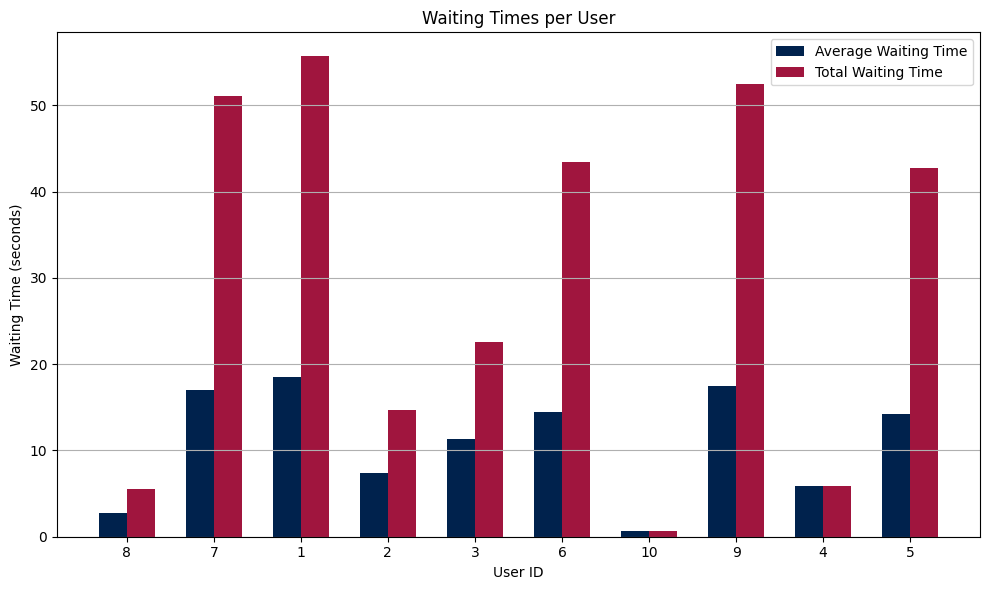

In [415]:
plot_waiting_times(task_records)

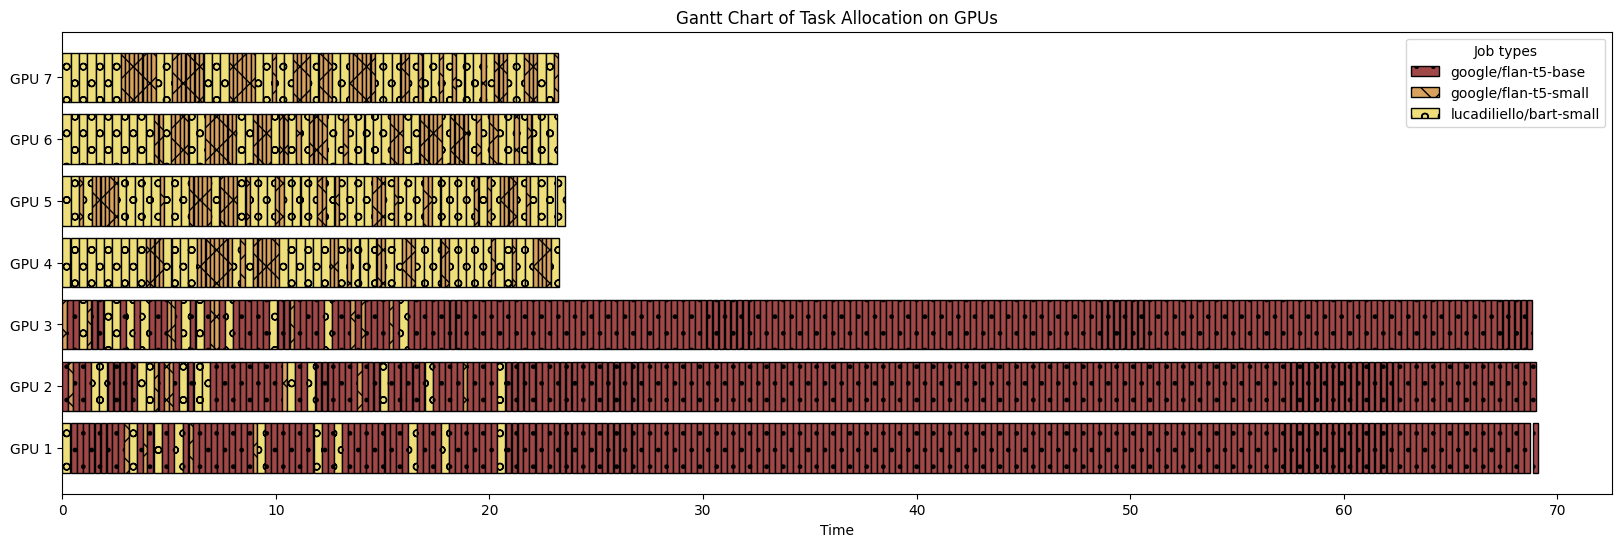

In [416]:
generate_gantt_gantt_executions(task_records)

<class 'numpy.ndarray'>
GPU 1 Tasks: 243, Total Training Time: 67.51616568273354, Unique Users: 10
GPU 2 Tasks: 243, Total Training Time: 67.51610521730495, Unique Users: 9
GPU 3 Tasks: 244, Total Training Time: 67.45547545775717, Unique Users: 10
GPU 4 Tasks: 76, Total Training Time: 22.832374517817758, Unique Users: 8
GPU 5 Tasks: 77, Total Training Time: 23.03237451781776, Unique Users: 8
GPU 6 Tasks: 79, Total Training Time: 22.68775261364042, Unique Users: 8
GPU 7 Tasks: 82, Total Training Time: 22.729286185507412, Unique Users: 8


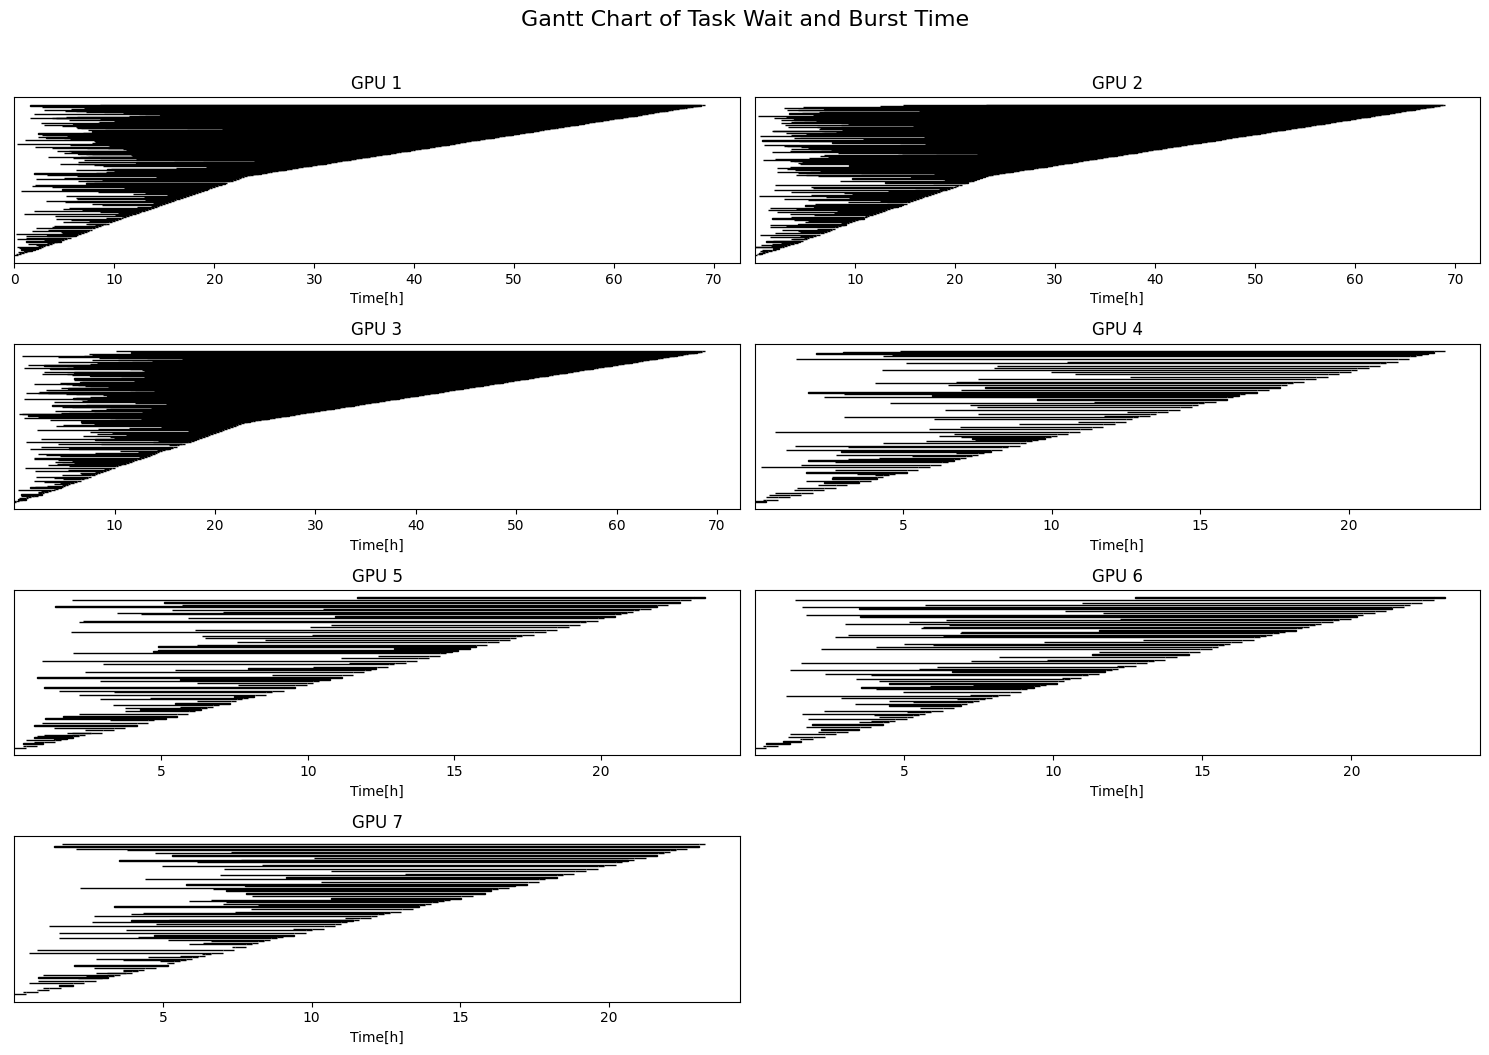

In [417]:
generate_gantt_arrival_ending_time(task_records)

### BENCHMARK

In [418]:
results_10users_3tasks_time = {
    "no_dare_no_session": {
        "gpu1": 73.79962100623446,
        "gpu2": 73.79962100623446,
        "gpu3": 82.08228342868003,
        "gpu4": 29.564128700823154,
        "gpu5": 33.130649689782246,
        "gpu6": 29.564128700823154,
        "gpu7": 24.847987267336684
    },
    "no_dare_yes_session": {
        "gpu1": 61.875489407910784,
        "gpu2": 57.795085747404066,
        "gpu3": 68.25978719432575,
        "gpu4": 33.57996997245287,
        "gpu5": 33.57996997245287,
        "gpu6": 26.756737701409293,
        "gpu7": 21.28146627837759
    },
    "yes_dare_no_session": {
        "gpu1": 67.51616568273354,
        "gpu2": 67.51610521730495,
        "gpu3": 67.45547545775717,
        "gpu4": 22.832374517817758,
        "gpu5": 23.03237451781776,
        "gpu6": 22.68775261364042,
        "gpu7": 22.729286185507412
    }
}

results_10users_3tasks_tasks = {
    "no_dare_no_session": {
        "gpu1": 73.79962100623446,
        "gpu2": 73.79962100623446,
        "gpu3": 82.08228342868003,
        "gpu4": 29.564128700823154,
        "gpu5": 33.130649689782246,
        "gpu6": 29.564128700823154,
        "gpu7": 24.847987267336684
    },
    "no_dare_yes_session": {
        "gpu1": 61.875489407910784,
        "gpu2": 57.795085747404066,
        "gpu3": 68.25978719432575,
        "gpu4": 33.57996997245287,
        "gpu5": 33.57996997245287,
        "gpu6": 26.756737701409293,
        "gpu7": 21.28146627837759
    },
    "yes_dare_no_session": {
        "gpu1": 10,
        "gpu2": 9,
        "gpu3": 10,
        "gpu4": 8,
        "gpu5": 8,
        "gpu6": 8,
        "gpu7": 8
    }
}

SyntaxError: expression expected after dictionary key and ':' (3485950115.py, line 21)